# Estimating risk-free probabilities using neural networks

## Introductory notes

One of the most widely used models to price options, by estimating the future price of the underlying is by using the binomial tree option pricing method.

It is a largely written about method, and is commonly used in a practical setting. And it takes the following logic.

Consider the price of the underlying $S_t$ at time $t$, now if you had to predict the price of the asset at time $T=t+n$, you would usually using any of the available time-series forecasting method. Another way is to assume that the price $S_t$ where $(t∈[T-n, T-n+1, ... , T - 1, T])$ is a random variable that follows a binomial distribution.

Then, at every step $t$, the probabilities can be estimated using the PMF of the binomial distribution, according to the probability of an up or a down movement. The usual approach in the binomial pricing tree is to match the probabilities according to the annualized volatility of returns. For short time periods, this is a favourable approach, but here we take in to consideration an approach which consists of neural networks to estimate the probability of an up and or a down movement, in order to get the $E[S_t+n]$.

In order to keep the explanation brief, we will continue with explaining the risk-free rate, the risk-free rate is the rate of return at which the potential investor faces **no risk**. To clarify what this means, imagine that you are getting a steady cashflow of income from a very liquid and stable security(for the United Stated this would be T-Bill, in Europe, it would be an Euro bond, or the German bonds), at a certain price $P$ and rate $r$. This means that you would, unless the Government of the chosen bonds defaults, have an almost sure quarterly, semi-annual or yearly income at that rate. Thus, if the rate of the return on the asset which you hold in your portfolio is less than the yield on the risk-free asset, it would make no sense to further hold the asset, since you are effectively missing out on earning more interest. The actual risk-free rate also has to be adjusted for inflation, thus the risk free rate comes out to be $R_f = r - inflation$ $rate$.

In this code, to keep things more simple, I have used $R_f = 0$, but a risk-free rate could be easily added to it, if needed. Below you can see the libraries used. 

There is more to be discussed here, but you can find additional reading on the material in the following links:
https://users.physics.ox.ac.uk/~Foot/Phynance/Binomial2013.pdf  
https://web.ma.utexas.edu/users/mcudina/bin_tree_lognormal.pdf

In [1]:
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats.mstats
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from BinaryTree import BinomialTree
from scipy.stats import reciprocal, lognorm, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics._scorer import make_scorer
from scipy import stats
from scipy.special import binom
import itertools
from typing import Optional, Any
from copy import deepcopy
import os

Here we define a subclass of the Binomial Tree which takes the additional parameters, such as the risk-free up-jump $u$, or the amount the stock moves up, and same for the down jump $d$, that matches the historical time-adjusted volatility of the asset, and conversly for the down-jump. The probabilites for the up and down movement, the function with wich to calculate the values of future prices, and the depth of the tree $n$.

In [2]:
class BinomialPriceTree(BinomialTree):
    def __init__(self, price: float, up_jump: float, down_jump: float, prob_u: float, prob_d: float,
                 func_price: callable, depth: int = 10):
        super().__init__(depth)
        self.price = price
        self.up_jump = up_jump
        self.down_jump = down_jump
        self.calc_price_function = func_price
        self.probability_up = prob_u
        self.probability_down = prob_d

    def calculate_prices(self) -> None:
        for a, branch in enumerate(self.tree):
            for b, node in enumerate(branch):
                node.data = self.calc_price_function(self.price, self.up_jump, self.down_jump, a, b)

    def calculate_expected_price(self, at_depth: int = None) -> npt.NDArray[float]:
        if at_depth is None:
            at_depth = len(self.tree) - 1
        temp_list = []
        for y, node in enumerate(self.tree[at_depth]):
            temp_list.append(binom(at_depth, y) * (self.probability_up ** (at_depth - y) * self.probability_down ** y) *
                             node.data)
        return np.sum(temp_list)

    def print_tree(self, *, return_matrix: bool = None) -> Optional[list[float]]:
        mesh = np.full((len(self.tree), 2 * len(self.tree) - 1), 0, dtype=float)
        for xy, z in zip(self.sorted_coo, self.flat_tree):
            mesh[xy[0]][xy[1]] = round(z.data, 2)
        mesh = mesh.T
        print(mesh)
        if return_matrix:
            return mesh

    def plot_tree(self) -> None:
        if not self.is_set_up:
            self.set_up()
        plt.plot(self.row_coo, self.y_coo_sorted, "ob")
        plt.yticks(np.arange(self.depth * 2 - 1))
        plt.xticks(np.arange(self.depth))
        temp_tree = deepcopy(self.tree)
        for branch in temp_tree:
            branch.reverse()

        temp_tree = list(itertools.chain(*temp_tree))

        for coo, node in zip(self.sorted_coo, temp_tree):
            plt.annotate(round(node.data, 2), (coo[0] - .05, coo[1] + .25))

        for x_coo in range(len(self.tree) - 1):
            for y in range(x_coo + 1):
                plt.plot([self.tree[x_coo][y].coo[0], self.tree[x_coo + 1][y].coo[0]],
                         [self.tree[x_coo][y].coo[1], self.tree[x_coo + 1][y].coo[1]], "k-")
                plt.plot([self.tree[x_coo][y].coo[0], self.tree[x_coo + 1][y + 1].coo[0]],
                         [self.tree[x_coo][y].coo[1], self.tree[x_coo + 1][y + 1].coo[1]], "k-")

        plt.show()

    def get_plot(self, x_offset: int) -> Any:
        if not self.is_set_up:
            self.set_up()
        temp_tree = deepcopy(self.tree)
        temp_coo = self.sorted_coo[:]
        for branch in temp_tree:
            branch.reverse()
        temp_fig, temp_ax = plt.subplots()

        temp_tree = list(itertools.chain(*temp_tree))
        offset_coo = map(lambda coo_lambda: (coo_lambda[0] + x_offset, coo_lambda[1]), temp_coo)
        for coo, node in zip(offset_coo, temp_tree):
            temp_ax.plot(coo[0], node.data, "ob")
            temp_ax.annotate(round(node.data, 2), (coo[0] - .10, node.data + 1))

        for x_coo in range(len(self.tree) - 1):
            for y in range(x_coo + 1):
                temp_ax.plot([self.tree[x_coo][y].coo[0] + x_offset, self.tree[x_coo + 1][y].coo[0] + x_offset],
                             [self.tree[x_coo][y].data, self.tree[x_coo + 1][y].data], "k-")
                temp_ax.plot([self.tree[x_coo][y].coo[0] + x_offset, self.tree[x_coo + 1][y + 1].coo[0] + x_offset],
                             [self.tree[x_coo][y].data, self.tree[x_coo + 1][y + 1].data], "k-")
        return temp_ax

The function print_tree is overriden in order to better match the data which is used here, the calculate expected price accepts an at_depth argument which you can use to calculate the expected value, according to the given probabilities at any timestep > t. 

Now we will go through the functions used in this demonstration.


In [3]:
def calculate_future_price(price: float, proba_up: float, proba_down: float, iter_1: int, iter_2: int) -> float:
    # formula for value at i-th step s_i_j = S_0 * u^i * d^(i-j)
    return price * (proba_up ** (iter_1 - iter_2)) * (proba_down ** iter_2)

For any given price $S_0$, the price at time_step i, node j by using the formula $S$<sub>$i,j$</sub> $ = S_0 * u^i * $ $d$<sup>$(i-j)$</sup>, in this functions, since we are looking at a transposed view, (column first, row second) the exponents change places in the function itself.

Next up is the function which calculates the actual parameters used:

In [4]:
def calculate_parameters_binomial(price_window: npt.NDArray, step_size: int = 1, r: float = 0) -> tuple[
        float, float, int, float]:
    up_jump = np.exp((price_window.std().iloc[0]) * np.sqrt(step_size / 10))
    down_jump = 1 / up_jump
    proba_up = (np.e ** (r * step_size) - down_jump) / (up_jump - down_jump)
    proba_down = 1 - proba_up
    return up_jump, down_jump, proba_up, proba_down

The formula used here is just one of the possible formulas for determining the $u$ and $d$, and the probability up $p(u)$ and $p(d)$, depending on the context various different formulas can be made to estimate the parameters, I have chosen this one since most of its assumptions are met, which will be discussed later. 

Then we have the functions which transforms the data set, into a windowed dataset with the 10 last observed prices, and then adds the price at len(time_window) - 1 and len(time_window) - 2, and here the price len(time_window) - 2 is used as a parameter to estimate the price at (len(time_window)) - 1. The data frame also includes the price which we use to predict the price at len(time_window) - 1, and this is the expected behaviour.

In [5]:
def create_feature_label_set(price_df: pd.DataFrame, window_length: int = 10) -> list[float]:
    temp_list = []
    for s in range(price_df.shape[0] - window_length):
        temp_window = price_df.iloc[s: s + window_length].reset_index()
        temp_window = temp_window.T
        temp_window.drop("index", axis=0, inplace=True)
        temp_window[window_length] = temp_window[window_length - 1]
        temp_window[window_length + 1] = price_df.iloc[s + window_length]
        temp_list.append(temp_window)
    return temp_list

There were two ways to design this neural network, one approach was to define a custom layer which uses the weight of the last layer (which is assumed to be a layer which outputs probabilities), and then use the custom layer as the output layer with the calculated prices, then look at the MSE for the actual price - predicted. Two auxiliary nodes would have to be made in order to capture the probabilities.

This approach seemed needlesly cumbersome to implement and use, thats why I went with taking the probabilities from the output layer, and using a custom error function for the CV and custom a custom loss function in the NN. Since we are predicting over a fairly short time-span, we want the model to be very sensitive to large losses, thus an MSE is a better fit to measure the loss of the model, than the RMSE. There are two version of the same function, the error returns a negative MSE, because the SciKit Learn RandomizedCV expects that larger is better, the loss returns the positive version.

In [6]:
def binomial_prediction_error(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    # the price at s_t we are trying to estimate is equal. s_t = pSu + (1-q)Sd, u and d we get from the above function
    s_t = y_true[:, 0] * y_pred[:, 0] * u + y_true[:, 0] * y_pred[:, 1] * d
    return tf.reduce_mean(tf.square(y_true[:, 1] - s_t))

In [7]:
def neg_binomial_prediction_error(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    # the price at s_t we are trying to estimate is equal. s_t = pSu + (1-q)Sd, u and d we get from the above function
    s_t = y_true[:, 0] * y_pred[:, 0] * u + y_true[:, 0] * y_pred[:, 1] * d
    return -1 * (tf.reduce_mean(tf.square(y_true[:, 1] - s_t))).numpy()

Here is the explanation how this error works, we have that, at $t=0$, $E[S0] = S0$, since by the assumptions of this model, we have that for the price in the up node $S_1$<sup>$up$</sup> $= S_0 * jump$<sup>$up$</sup>, and for the price in the down node we have that $S_1$<sub>$down$</sub>$= S_0 * jump$<sub>$down$</sub>, given a probability $p$ (in this case risk neutral) we have that $E[S_1] = p * S_0 * jump$<sup>$up$</sup> $ +  (1-p) * S_0 * jump$<sub>$down$</sub>. So the actuall loss of the model is $MSE(S_1, E[S_1])$, note that here it is explicitly stated that the probability for the down price has to be equal to 1-p, because each layer of the tree has to follow the sub-additive property, in other words let $a$ be a fixed layer $i$ in the tree, then $∀a ∈ i$, $\Sigma$<sub>$a, j∈a$</sub>  $p(S$<sub>$a,j$</sub>$) = 1$  

Here is the function which builds the model, it is a fairly simple function, and a fairly simple model which just accepts the input parameters, with added batch normalization, to scale the inputs, and the he initialization to scale variance of the outputs of the neurons.

In [8]:
def build_model(hidden_layers: int = 1, no_of_neurons: int = 100, lr: float = 25e-3, drop_out: float = .20,
                recurrent_drop_out: float = .20):
    model = keras.models.Sequential()
    for layer in range(1, hidden_layers):
        model.add(keras.layers.LSTM(no_of_neurons, dropout=drop_out, recurrent_dropout=recurrent_drop_out,
                                    return_sequences=True))
    if hidden_layers > 0:
        model.add(keras.layers.LSTM(no_of_neurons, dropout=0.2, recurrent_dropout=0.2))
    model.add(keras.layers.Dense(2, activation="softmax"))
    model.compile(loss=binomial_prediction_error, optimizer=keras.optimizers.Adam(learning_rate=lr))
    return model

Following function is pretty common, it's used to standardize the data later on

In [9]:
def standard_scale(data, mean, deviation):
    return (data - mean) / deviation

In order to meet the assumptions of the binomial tree model, the logarithimic returns $log(s_t / $log<sub>$t-1$</sub>$)$ have to follow a normal distribution. This is very common in finance, since the prices themselves ofter follow a geometric progression, and are thus considered to follow a geometric random walk with the parameters $(\mu, \sigma)$. Where $\sigma$ usually should grow with a factor of $\sqrt t$. Shown below:

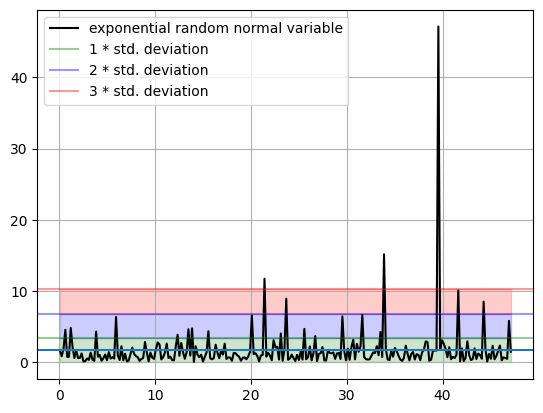

In [10]:
# ensures reproducibility
np.random.seed(42)
tf.random.set_seed(42)

random_exponential_normal = np.exp(np.random.randn(250))  # 250 samples of the normal distribution with mean=0 and std=1

exponential_normal_mean = random_exponential_normal.mean()
exponential_normal_std = random_exponential_normal.std()

x = np.linspace(np.min(random_exponential_normal), np.max(random_exponential_normal), 250)

plt.plot(x, random_exponential_normal, color="black", label="exponential random normal variable")
plt.axhline(y=exponential_normal_mean)

for scalar, color in enumerate(("green", "blue", "red")):
    plt.axhline(y=(scalar + 1) * exponential_normal_std, color=color, label=f"{scalar + 1} * std. deviation", alpha=.4)
    plt.fill_between(x, scalar * exponential_normal_std, (scalar + 1) * exponential_normal_std, color=color, alpha=0.2)

plt.grid()
plt.legend()
plt.show();

From the graph, clearly seen is that most of the data should fall within one standard deviation from the mean, a smaller portion should be outside the $2 * \sigma$ range, and a very small fraction of the data should lie outside the $3 * \sigma$ range. This is what a normal distribution should like according to the Chebyshev/Theoretical rule. But the log-normal distribution is usually right-skewed, and this does not provide a good enough analysis in order to conclude that the data is log-normally distributed.

Below we can see, that it seems that most of the prices for the NVIDIA stock opening retrieved from Yahoo Finance, does fall within one standard deviation from the mean. Analagously, a comparison could be made for the second and the third deviation, but here we will limit the analysis, since it will most probably not be suitable to accept the hypothesis that the data is log-normally distributed. If the same analysis were suitable we could analyze the standardized residuals $Z$ to check which percentage of residuals falls within $-1 < Z < 1$, $-2 < Z < 2$, $-3 < Z < 3$ and so forth.

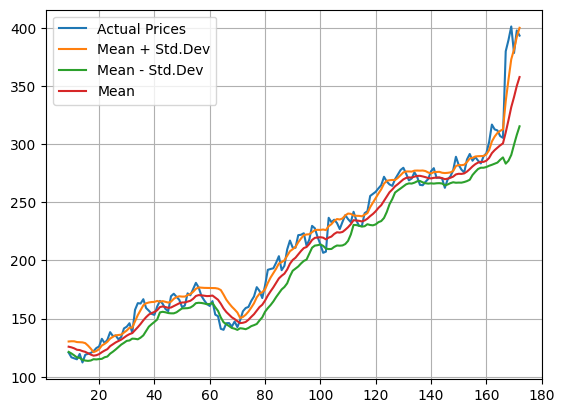

In [11]:
WINDOW_SIZE = 10

nvidia_data = pd.read_csv(os.curdir + r"\NVDA.csv")
nvidia_prices = nvidia_data.loc[:, "Close"]
rolling_prices = nvidia_prices.rolling(WINDOW_SIZE)
rolling_prices_mean, rolling_prices_std = rolling_prices.mean(), rolling_prices.std()

rolling_sigma_prices_upper = rolling_prices_mean + rolling_prices_std
rolling_sigma_prices_lower = rolling_prices_mean - rolling_prices_std

for prices, labels in zip(
        (nvidia_prices[WINDOW_SIZE - 1:], rolling_sigma_prices_upper, rolling_sigma_prices_lower, rolling_prices_mean),
        ("Actual Prices", "Mean + Std.Dev", "Mean - Std.Dev", "Mean")):
    prices.plot(label=labels)

plt.legend()
plt.grid()
plt.show();

In [12]:
stndrdized_prices = (nvidia_prices - nvidia_prices.mean()) / nvidia_prices.std()
stndrdized_prices

0     -1.269703
1     -1.242432
2     -1.194819
3     -1.270882
4     -1.282822
         ...   
168    2.668763
169    2.840494
170    2.504844
171    2.790228
172    2.724925
Name: Close, Length: 173, dtype: float64

We can also take a look at the log returns histogram in order to look at the distribution.

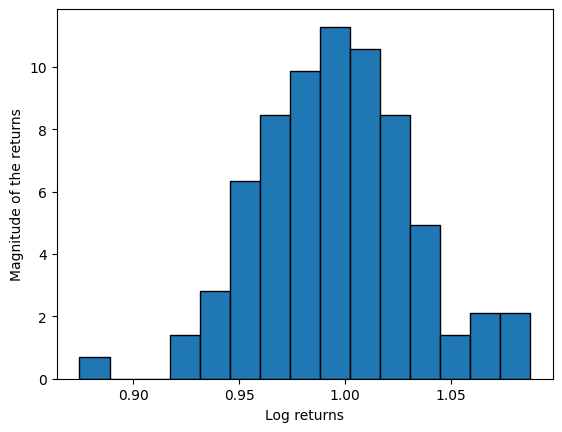

In [13]:
train_set_prices = nvidia_prices[:101]
prices_t_1 = train_set_prices.iloc[:-1].reset_index()
prices_t_0 = train_set_prices.iloc[1:].reset_index()
prices_t_0.drop("index", axis="columns", inplace=True)
prices_t_1.drop("index", axis="columns", inplace=True)

p = log_returns = prices_t_1 / prices_t_0

plt.hist(p, density=True, bins=15, ec="black")
plt.xlabel("Log returns")
plt.ylabel("Magnitude of the returns")
plt.show()

But this approach, usually fails to satisfy, since the conclusion about the normality of the distriubtion depends on the binning used. For a better judgement, of the same type of analysis, Q-Q plots can be used. They are simply the percentiles of the data, plotted against the theoretical log-normal distribution wih the $\sigma$ being equal to the volatility of the log-returns.

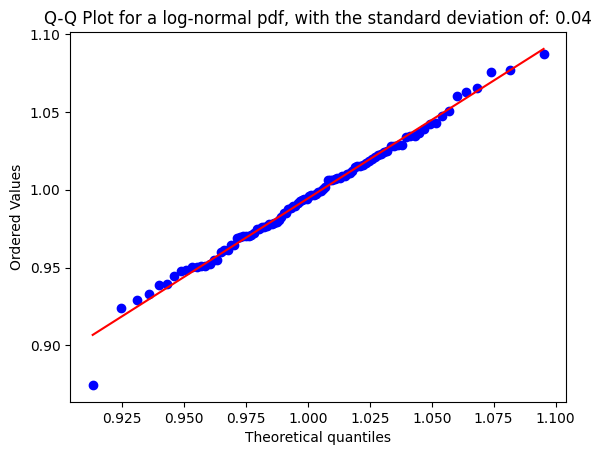

In [14]:
for_q_plot = np.array(p.iloc[:])
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(for_q_plot.ravel(), sparams=(p.std().iloc[0]), dist=lognorm, plot=ax)
ax.set_title(f"Q-Q Plot for a log-normal pdf, with the standard deviation of: {p.std().iloc[0]:.2f}")
plt.show()

Here we can see that we have a pretty good fit to the theoretical quantiles, thus we will go ahead with using the model. One more thing that could be done to check for the normal distribution test on the returns, here we will use the basic test, since we already made the conclusion, but for completness sake, here is the pearson's normality test.

In [15]:
print(scipy.stats.mstats.normaltest(log_returns))

NormaltestResult(statistic=masked_array(data=[1.0585245685196645],
             mask=[False],
       fill_value=1e+20), pvalue=array([0.58903935]))


Since the p-value is greather than 0.05 we reject the hypothesis that the returns do not come from a normal distribution.

Next part of the code simply, as stated before calculates the parameters, and also reshapes the training set. Also, a wrapper around a keras regressor is made in order to use it for CV later on. This has been deprecated, but I will probably adjust the code to work with the suggestion that comes in the warning.

In [17]:
u, d, p_u, p_d = calculate_parameters_binomial(log_returns, WINDOW_SIZE)

labeled_set = np.array(create_feature_label_set(nvidia_prices, WINDOW_SIZE))
labeled_set = labeled_set.reshape(-1, WINDOW_SIZE + 2)

# dummy_y variable is needed so that the train_test_split can work with RNN models
dummy_y = np.zeros(labeled_set.shape)
x_train_full, x_test, *_ = train_test_split(labeled_set, dummy_y, train_size=0.8, test_size=0.2)
dummy_y = np.zeros(x_train_full.shape)

x_train, x_val, *_ = train_test_split(x_train_full, dummy_y, train_size=0.8, test_size=0.2)
x_windows, y_prices = x_train[:, :-2], x_train[:, -2:]
x_val_windows, y_val_prices = x_val[:, :-2], x_val[:, -2:]

x_windows = x_windows.reshape(-1, WINDOW_SIZE, 1)  # reshaped for as a seq for RNN models
kerasreg_cv = keras.wrappers.scikit_learn.KerasRegressor(build_model)

param_distribs = {
    "hidden_layers": randint(2, 10),
    "no_of_neurons": randint(10, 500),
    "lr": reciprocal(3e-4, 3e-2),
    "drop_out": reciprocal(2e-1, 5e-1),
    "recurrent_drop_out": reciprocal(2e-1, 5e-1),
}

neg_bin_scorrer = make_scorer(neg_binomial_prediction_error, greater_is_better=True)

scale_mean, scale_deviation = np.mean(x_windows), np.std(x_windows)

x_windows_train, y_prices, x_val_windows, y_val_prices = map(
    lambda dataset: standard_scale(np.log(dataset), scale_mean, scale_deviation),
    [x_windows, y_prices, x_val_windows, y_val_prices])

C:\Users\emirs\AppData\Local\Temp\ipykernel_13996\211367462.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  kerasreg_cv = keras.wrappers.scikit_learn.KerasRegressor(build_model)


Next up, the Cross-Validation is performed with an early stopping callback in order to reduce the run-time of the process. Another callback in order to save the weights could be made, or for tensorboard, but this is purely for demonstrational purposes.

In [18]:
rnd_search_cv = RandomizedSearchCV(kerasreg_cv, param_distributions=param_distribs, n_iter=1, cv=2,
                                   scoring=neg_bin_scorrer)
rnd_search_cv.fit(x_windows_train, y_prices, epochs=5, validation_data=(x_val_windows, y_val_prices),
                  batch_size=1, verbose=2, callbacks=[keras.callbacks.EarlyStopping(patience=10),
                                                      keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.9,
                                                                                        patience=5)])
print(f"Best parameters: {rnd_search_cv.best_params_},\n best_score: {rnd_search_cv.best_score_}")

bin_model = rnd_search_cv.best_estimator_.model
print(bin_model.summary())

Epoch 1/5
52/52 - 34s - loss: 3.0157e-06 - val_loss: 3.6131e-07 - lr: 0.0024 - 34s/epoch - 649ms/step
Epoch 2/5
52/52 - 21s - loss: 1.1994e-06 - val_loss: 3.6071e-07 - lr: 0.0024 - 21s/epoch - 397ms/step
Epoch 3/5
52/52 - 21s - loss: 1.0539e-06 - val_loss: 2.9364e-07 - lr: 0.0024 - 21s/epoch - 401ms/step
Epoch 4/5
52/52 - 22s - loss: 1.1190e-06 - val_loss: 7.6700e-07 - lr: 0.0024 - 22s/epoch - 430ms/step
Epoch 5/5
52/52 - 22s - loss: 8.8630e-07 - val_loss: 4.3606e-07 - lr: 0.0024 - 22s/epoch - 423ms/step
2/2 [==============================] - 3s 154ms/step
Epoch 1/5
52/52 - 42s - loss: 1.8644e-06 - val_loss: 3.2390e-07 - lr: 0.0024 - 42s/epoch - 799ms/step
Epoch 2/5
52/52 - 22s - loss: 6.9890e-07 - val_loss: 6.8032e-07 - lr: 0.0024 - 22s/epoch - 427ms/step
Epoch 3/5
52/52 - 22s - loss: 9.7730e-07 - val_loss: 9.1801e-07 - lr: 0.0024 - 22s/epoch - 414ms/step
Epoch 4/5
52/52 - 22s - loss: 1.0296e-06 - val_loss: 1.7909e-06 - lr: 0.0024 - 22s/epoch - 414ms/step
Epoch 5/5
52/52 - 22s - loss:

After obtaining the results from the best fitting model, we can obtain the probabilities, as show below.

In [19]:
print("model probabilities:")
predicted_probabilities = bin_model.predict(x_test[:, :-2, np.newaxis])

np.set_printoptions(suppress=True)
print(predicted_probabilities)

model probabilities:
2/2 [==============================] - 2s 77ms/step
[[0.48947442 0.5105256 ]
 [0.4894083  0.5105917 ]
 [0.48944798 0.510552  ]
 [0.48942506 0.51057494]
 [0.4894135  0.51058656]
 [0.48941392 0.5105861 ]
 [0.48942393 0.51057607]
 [0.48941895 0.5105811 ]
 [0.4894766  0.51052344]
 [0.4894303  0.51056975]
 [0.4894542  0.51054585]
 [0.48942393 0.510576  ]
 [0.4894561  0.5105439 ]
 [0.48941323 0.5105868 ]
 [0.4894099  0.5105901 ]
 [0.48943046 0.5105696 ]
 [0.4894685  0.5105315 ]
 [0.48942414 0.51057583]
 [0.48942873 0.5105713 ]
 [0.48946416 0.51053584]
 [0.48945627 0.5105437 ]
 [0.48944846 0.5105516 ]
 [0.48947605 0.510524  ]
 [0.48941442 0.51058555]
 [0.48945716 0.51054287]
 [0.48943847 0.51056147]
 [0.48945063 0.5105494 ]
 [0.48942828 0.5105717 ]
 [0.48948175 0.51051825]
 [0.4894773  0.5105227 ]
 [0.4894042  0.51059574]
 [0.4894829  0.51051706]
 [0.48941293 0.51058704]]


Here we will make three different time series to use for the MSE on the test set, in order to compare the model using the estimated probabilities with the baseline classic approach model.

In [20]:
x_test_model = np.log(x_test)
x_test_model = standard_scale(x_test_model, scale_mean, scale_deviation)

price_probas_bin_ml = bin_model.predict(x_test_model[:, :-2, np.newaxis])
predicted_prices_ml = price_probas_bin_ml * x_test[:, -2:-1] * [u, d]
predicted_prices_ml = [np.sum(x) for x in predicted_prices_ml]

predicted_prices_classic_fixed_probabilities = x_test[:, -2:-1] * [u, d] * [p_u, p_d]
predicted_prices_classic_fixed_probabilities = [np.sum(x) for x in predicted_prices_classic_fixed_probabilities]

2/2 [==============================] - 1s 88ms/step


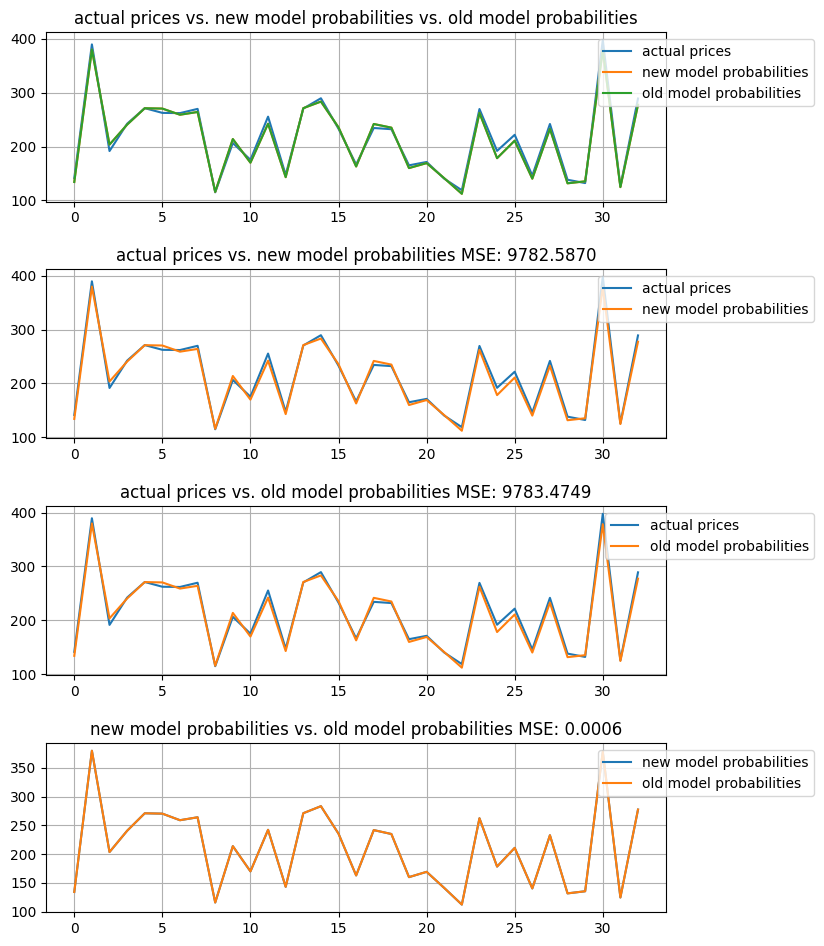

In [22]:
def calculate_mse(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))


dict_all = {"actual prices": x_test[:, -1:],
            "new model probabilities": np.array(predicted_prices_ml),
            "old model probabilities": np.array(predicted_prices_classic_fixed_probabilities),
            }

subplot_no = 411
all_labels = tuple([*dict_all.keys()])

for combination in [all_labels] + list(itertools.combinations(all_labels, 2)):
    ax = plt.subplot(subplot_no)
    temp_data = []
    for label in combination:
        ax.plot(dict_all[label], label=label)
        if len(combination) < 3:
            temp_data.append(dict_all[label])
    title = " vs. ".join(combination)
    if len(temp_data) > 0:
        current_MSE = calculate_mse(*temp_data)
        title = title + f" MSE: {current_MSE:.4f}"
    ax.set_title(title)
    plt.grid()
    plt.legend(bbox_to_anchor=(1.25, 1), loc="upper right")
    subplot_no += 1

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.789,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.rcParams['figure.figsize'] = [9, 11]
plt.show()

As seen from the graph, the model as of now slightly outperforms the classic approach, with very little training, and without using batch learning. This is partly expected, since we are using a fixed set of probabilities over the hole training set, but that is one of the limitations, and critiques of the classical approach.

Also the NN could be further expanded upon with additional training, and additional data transformations, for instance we could actually try to predict the price changes instead of the actual prices. Also LSTM cells are great when using datasets where having memory is useful. For instance you could use this model in order to predict the prices at the same time next year, when there is a dividend payout announcement.

Also this model could be used for dynamic hedging strategies, and option valuation as usual. We still make the assumption that the returns are normally distributed, the only thing that is different is probability of the up move and the probability of the down move.

## Conclusion

This marks the end of the demonstration, we have seen that it can outperform on the test data the classic binomial tree model, and could be used to model asset prices. Several extensions could be made to enhance the model, but still this is satisfactory for a quick model on new assets which you may just have put in the portfolio.

You can get the graph of the model by using the following statements.

In [23]:
all_probs = bin_model.predict(x_test[:1, :-2, np.newaxis])
print("all probabilities:", all_probs)

probability_up = all_probs[0][0]
probability_down = all_probs[0][1]

print(f"{probability_up=}, {probability_down=}")

1/1 [==============================] - 0s 96ms/step
all probabilities: [[0.48947442 0.5105256 ]]
probability_up=0.48947442, probability_down=0.5105256


create tree called


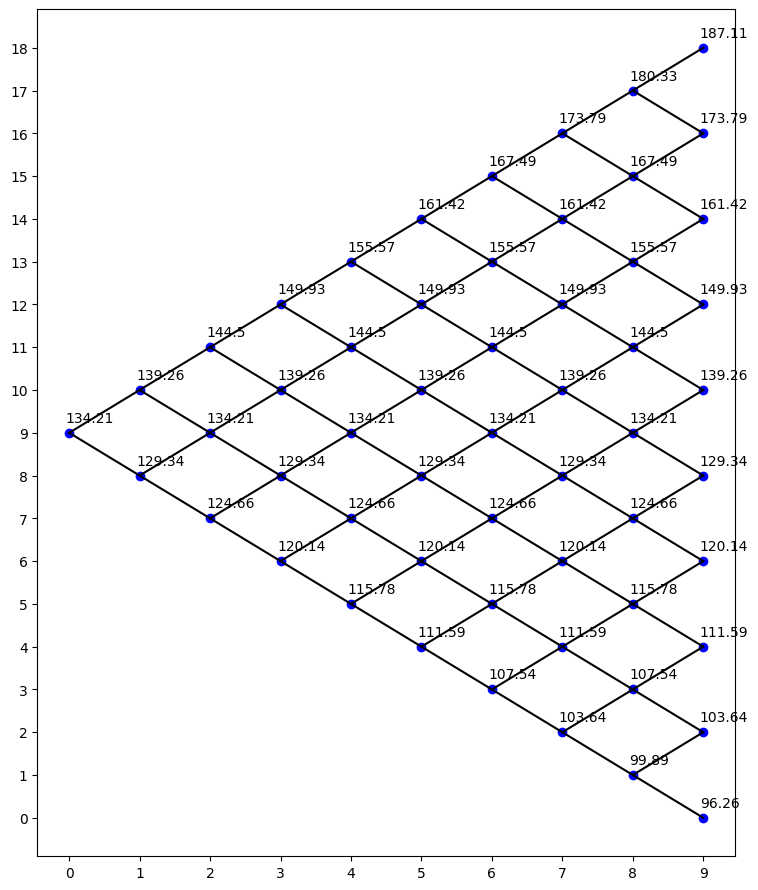

[[  0.     0.     0.     0.     0.     0.     0.     0.     0.   187.11]
 [  0.     0.     0.     0.     0.     0.     0.     0.   180.33   0.  ]
 [  0.     0.     0.     0.     0.     0.     0.   173.79   0.   173.79]
 [  0.     0.     0.     0.     0.     0.   167.49   0.   167.49   0.  ]
 [  0.     0.     0.     0.     0.   161.42   0.   161.42   0.   161.42]
 [  0.     0.     0.     0.   155.57   0.   155.57   0.   155.57   0.  ]
 [  0.     0.     0.   149.93   0.   149.93   0.   149.93   0.   149.93]
 [  0.     0.   144.5    0.   144.5    0.   144.5    0.   144.5    0.  ]
 [  0.   139.26   0.   139.26   0.   139.26   0.   139.26   0.   139.26]
 [134.21   0.   134.21   0.   134.21   0.   134.21   0.   134.21   0.  ]
 [  0.   129.34   0.   129.34   0.   129.34   0.   129.34   0.   129.34]
 [  0.     0.   124.66   0.   124.66   0.   124.66   0.   124.66   0.  ]
 [  0.     0.     0.   120.14   0.   120.14   0.   120.14   0.   120.14]
 [  0.     0.     0.     0.   115.78   0.   115.78 

In [25]:
price_t0 = x_test[:, -2:-1]

predictedProbabilityPrice = BinomialPriceTree(price_t0[0][0], u, d, probability_up, probability_down,
                                              calculate_future_price)
predictedProbabilityPrice.calculate_prices()
predictedProbabilityPrice.plot_tree()
predictedProbabilityPrice.print_tree(return_matrix=False)
print("Expected price: ", predictedProbabilityPrice.calculate_expected_price())

You can also overlay the graph over a subset of the prices to see how well the model captures the the volatility of the price movement. Ideally, the model will have a small enough volatility in order to capture the price movement. From the graph below, we can see that the prices never go outside of the bounds of the model, which is certainly great, and is used for backtesting the model.

create tree called


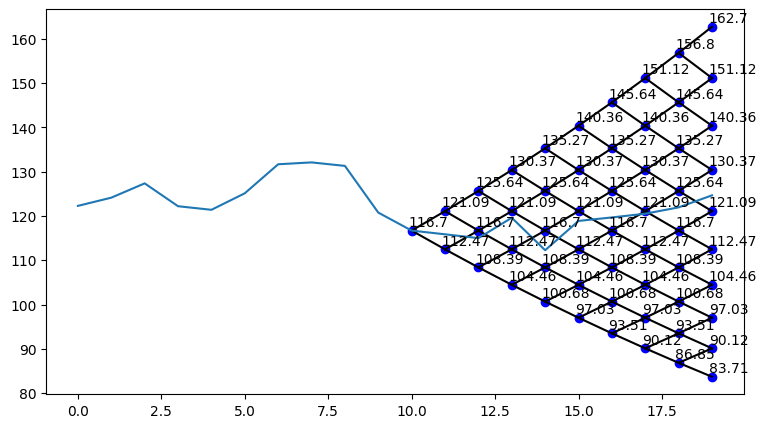

In [35]:
binTree = BinomialPriceTree(nvidia_prices.iloc[WINDOW_SIZE], u, d, probability_up, probability_down,
                            calculate_future_price)
binTree.calculate_prices()

off_tree = binTree.get_plot(WINDOW_SIZE)
off_tree.plot(nvidia_prices.iloc[:20])
plt.show();